# Ground Based Observation


If you make observations on the ground, the biggest problem is the atmosphere. The atmosphere makes two important problems:

* Seeing
* Extinction (= scattering + absorption)

In the following, we will explore what seeing and extinction are, and learn how to get the "real" magnitude from instrumental magnitude (called the **standardization** process).

Finally, I will show you some examples for you to understand how to do the real standardization process.

-----

## 1. Seeing


Seeing is one of the critical problems. You may refer to [here](https://drive.google.com/open?id=0B-MLFRYnMxUvWTNiZjhaZHA1cnM) and grasp the meaning of seeing. In this section, I will ignore the instrumental seeing, which usually is a low-frequency component.

Because of the atmospheric seeing, the point source is smoothed from its own "point". The function which describes this spreadness is called the **point spread function**, or just **psf**.

There are two most widely used analytic psfs: [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function) and [Moffat](https://en.wikipedia.org/wiki/Moffat_distribution). The first suggestion of using Moffat profile was made in 1969 by A. F. J. Moffat in [this paper](http://adsabs.harvard.edu/cgi-bin/bib_query?bibcode=1969A%26A.....3..455M&db_key=AST) (Astronomy and Astrophysics, Vol. 3, p. 455 (1969)). 

Among parameters for psfs, one that is very widely used in astronomy is the FWHM (full width at half-maximum). FWHM is defined as the distance between the two points which have the value $\frac{1}{2} f_{\rm max}$. FWHM is also used for Lorenzian profile, which has infinite standard deviation (the second centered moment diverges, so the standard deviation is not defined, but FWHM can). The profiles of two psfs and their FWHMs are described below:

### 1.1. Gauss
The circular, i.e., azimuthally symmetric Gauss psf is like this:

$$ f_{\rm Gauss}(r) = A e^{ -(r-r_0)^2/2\sigma^2 } $$

Here, $r$ is the distance from the center, $r_0$, and $\sigma$ is the standard deviation of the profile. The normalization constant $A = \frac{1}{\sqrt{2 \pi \sigma^2}}$, such that the integration $ \int_{-\infty}^{+\infty} f_{\rm Gauss}(r) 2\pi r dr = 1$. 

The FWHM is calculated by setting $f_{\rm Gauss}(r_{1/2}) = \frac{A}{2}$. First we obtain

$$ (r_{1/2} - r_0)^2 = 2 \log_e 2 \sigma^2$$

and thus

$$ {\rm FWHM} := 2(r_{1/2} - r_0) = 2 \sqrt{2 \log_e 2} \sigma ~.$$

### 1.2. Moffat
The circular, i.e., azimuthally symmetric Moffat psf is like this:

$$f_{\rm Moffat} (r) = A \left [ 1 + \left ( \frac{r-r_0}{R} \right )^2 \right ]^{-\beta} ~.$$

Here, $r$ is the distance from the center, $r_0$, as in Gauss psf. By integration, $ \int_{-\infty}^{+\infty} f_{\rm Moffat}(r) 2\pi r dr = 1$, I obtained the normalization constant $ A = \frac{\beta - 1}{\pi R^2} $. The parameter $R$ is called the core width and $\beta$ is called the power. In [astropy Moffat 2D](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat2D.html#astropy.modeling.functional_models.Moffat2D), `gamma` is used for the core width ($R$), and `alpha` is used for the power ($\beta$), which might be confusing. [IRAF Moffat 2D](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psfmeasure) uses `alpha` as the core width ($R$) and `beta` for the power ($\beta$), which has been a more standard notation in astronomy. Moffat considered atmospheric turbulence, instrumental abberation, and photographic receiver when he first instroduced this profile, althought the profile itself is empirical.

The FWHM is calculated by setting $f_{\rm Moffat}(r_{1/2}) = \frac{A}{2}$. As we did in Gauss example, we obtain

$$ (r_{1/2} - r_0)^2 = R^2 (2^{1/\beta}-1) $$

and thus

$$ {\rm FWHM} := 2(r_{1/2} - r_0) = 2 R \sqrt{2^{1/\beta}-1} ~.$$

### 1.3. Comparison (Gauss VS Moffat)

In uniform atmospheric seeing condition and long exposure time, psf should converge to a symmetric shape, i.e., isophotal curves should look like a concentric circles. It actually is rarely the case. We encounter elliptical, or even irregularly shaped isophotes. In such cases, you may make elliptical model rotated by certain angle, or simulate the seeing. Those fitting or simulation can be done using Astropy if necessary. Usually we believe the tracking is perfect, and use circular aperture. 

In the following example, I will show you the difference between Gaussian and Moffat in 1-D simple case.

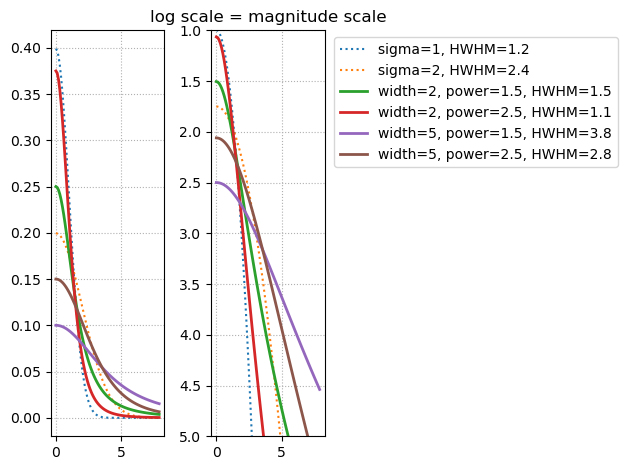

In [1]:
from astropy.modeling.functional_models import Moffat1D, Gaussian1D
from scipy.special import gamma as G
import numpy as np
from matplotlib import pyplot as plt

def norm_gauss(sigma):
    return 1/np.sqrt(2 * np.pi * sigma**2)

def norm_moffat(width, power):
    return G(power) / (width * np.sqrt(np.pi) * G(power - 1/2))

def HWHM_moffat(width, power):
    return width * np.sqrt( 2**(1/power) - 1)

x       = np.arange(0,8,0.1)
sigma   = np.array([1, 2])
width   = np.array([2, 5])
power   = np.array([1.5, 2.5])


ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for s in sigma:
    gauss  = Gaussian1D(amplitude=1, mean=0, stddev=s)    
    ax1.plot(x, norm_gauss(s)*gauss(x), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))
    ax2.plot(x, -2.5 * np.log10(norm_gauss(s)*gauss(x)), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))

for w in width:
    for p in power:
        moffat = Moffat1D(amplitude=1, x_0=0, gamma=w, alpha=p)
        HWHM   = HWHM_moffat(w, p)
        ax1.plot(x, norm_moffat(w, p) * moffat(x), lw=2,
                 label='w={0:.0f}, p={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))
        ax2.plot(x, -2.5*np.log10(norm_moffat(w, p) * moffat(x)), lw=2,
                 label='width={0:.0f}, power={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))

ax1.grid(ls=":")
ax2.grid(ls=":")
ax2.set_ylim(1, 5)
ax2.invert_yaxis()
ax2.set_title('log scale = magnitude scale')
plt.legend(bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

Moffat describes in his 1969 paper that

> Two-dimensional intensity profiles of focal stellar images in photographic emulsions were derived by convolving gaussian seeing distributions with diffraction proffles and emulsion scattering functions. **The results predict too low an intensity for large radial distances from the centre of the image**, contradicting the assumption that seeing is gaussian.

He noted that the stellar profile is too bright than the good-fitted Gaussian at larger radius, and this contradicts with the old assumption that seeing profile is Gaussian. This can be seen from the above figure I drew. Compare blue dotted (Gauss) and red solid lines (Moffat). The HWHMs are 1.2 and 1.1, so you may expect the latter to have more "concentrated" profile. But at radius larger than about 1.5, latter becomes larger. 

This means the Gaussian fitting may not always be a good choice, especially in the presence of atmosphere.

* **Question**: Why do you think I let the abscissa to be in a logarithmic scale? Can you guess what the $\log_{10}$ of stellar profile means?

* **TIP**: The reason I normalized psfs is that I wanted to simulate the psf of the same star with different atmospheric condition. The total flux of the star should be constant, but the psf changes due to the seeing.
-----

## 2. Extinction

Because of the atmosphere, stellar flux diminishes because of **absorption** and **scattering**. It is mainly because of the change in weather; the same star can appear to have different flux every time, even though the exposure time and instruments are exactly the same. This of course depends on the thickness of atmosphere in the line of sight. More complicated issue is that this extinction is also a function of wavelength, so you have to apply different extinction factor for different filters, *in principle*. 


### 2.1. Atmospheric Extinction
Under parallel uniform atmosphere assumption, the flux diminishes by a factor of $e^{-\tau}$, where $\tau$ is the optical depth. In magnitude system, i.e., the logarithmic scale, this means the increase in magnitude is proportional to the airmass, $X = \sec(z)$: 

\begin{equation}
    m(X) = m_0 + k_X X
\end{equation}

where $m$ is the observed magnitude, $m_0$ is the magnitude if it were not for the atmosphere, and $k_X$ is a constant called the *extinction coefficient*.


### 2.2. Wavelength Dependence
It is natural that the extinction, which include absorption and scattering, depends on wavelength. In [Rayleigh regime](https://en.wikipedia.org/wiki/Rayleigh_scattering), i.e., when wavelength is much longer than particles ($x \ll \lambda$ where $x$ is the size parameter), the extinction is approximately proportional to $\lambda^{-4}$. So shorter wavelength must have larger $k_X$ value, which means it suffers more extinction from atmosphere. 

> $k_X$ is actually a wavelength dependent one ($k_{X, \lambda}$). Typical values are
 * 0.4 in U-band
 * 0.2 in B-band
 * 0.1 in V-band


In broad-band observation, the word "wavelength" can be substituted by "filter". For example, if we want the V band magnitude, we need to find coefficients $a$ and $k_{XC}$ from 

\begin{equation}
    m_V = m_{V, 0} + k_{X, V} X + a({\rm B}-{\rm V}) + k_{XC, V} X ({\rm B}-{\rm V}) ~.
\end{equation}

You can use U, R, I, or any other bands instead of B, but I used B which is conventional. The subscript C in $k_{XC}$ means "color".

Fortunately, $a$ is very small ($|a| \lesssim 0.1$), and $k_{\rm XC}$ is nearly zero for most instances. Considering B-V color is usually less than unity, you can see that the color terms (the third and the fourth term) will be very negligible. Especially the introduction of $k_{XC}$ increases the uncertainty in many cases, so it is not usually used unless the sky is very clear.

> The color dependent terms ($k_{XC, V}$ and even $a$) is not very useful unless you need very precise determination.


-----

## 3. Zero-point

What we will calculate from program or software is just $m_{\rm inst} = 2.5 \log_{10} ({\rm photon~count~per~1s})$ (the **instrumental magnitude**). In such cases, even the Moon may appear to have magnitude of only 10-mag or so, which is non-sensical. The normalization to photon count can be done by subtracting certain value from instrumental magnitude, which is mathematically identical to the normalization using 0-mag star (think about Pogson's formula). 

The correction to this kind of problem is done by **zeropoint** magnitude. If the zeropoint is denoted as $m_z$, we get the real magnitude as $m = m_{\rm inst} - m_z$.

-----

## 4. Standardization

### 4.1. Idea
Combining the zeropoint correction and extinction correction and ignore the color terms, we get

\begin{equation}
	m_{0, V} = m_{{\rm inst}, V} - m_{z, V} - k_{X, V} X \quad( - {\rm color~correction~terms})~,
\end{equation}

or more frequently, changing $m_{0, V} $ to $V$, $m_{{\rm inst}, V}$ to $v$, etc, 

\begin{equation}
	v - V = z_{V} + k_{V} X \quad( + {\rm color~correction~terms})~,
\end{equation}

for V-band, as an example. Conventionally people use upper case for the actual (apparent) magnitude and lower case for instrumental (apparent) magnitude. 

This process, *transforming the instrumental magnitude to the "real" magnitude*, is called the **standardization**.


### 4.2. Standardization in Practice

Now, how do we get $m_z$ and $k_X$? What we know is only $X$ and what we can calculate is only $m_{\rm inst}$! Fortunately, we have some stars which have very accurately known $m_0$ values. These are called the **standard stars**. Some famous ones are **Landolt standard stars**.

So the strategy is clear: Take images of standard stars at different airmasses, at nearly identical sky conditions. Plot $m_{\rm inst} - m_0$ VS $X$, and the slope and intercept will be $k_X$ and $m_z$, respectively. This is only true when we neglect the wavelength (or color) dependency of extinction. Note that these two depends on sky condition, i.e., **these should be determined at each night**, in principle.

The easiest case occurs if the targets of interst are at almost identical zenith distance (i.e., constant $X$). Observation of a bright star cluster is such a case. Then we can regard $k_X X$ as a constant, and set it as part of $m_z$, so $ m_0 = m_{\rm inst} - m_z' $.




-----

## Example 1: Calculating Instrumental Magnitude and Color

Consider you have obtained images of two objects and three standard stars. (I have obtained these data from the tutorial examples of a class which I took in 2016, and the data are not very realistic, but good enough to use for our example, so I adopted)


Each of the standard stars was taken at three different airmasses, named `X`: 1.0, 1.3, and 2.0. The exposure time in V and B bands are `T_B` and `T_V`. The photon counts are given in `count_V` and `count_B`. Say the gain value `gain=1.0` and ignore the readout noise. Also assume the sky conditions were prefectly good during the observation. 

> **How can we calculate the magnitudes, colors, and their uncertainties?** 

For brevity, I will use lower cased letters, `b` and `v` for the *instrumental* magnitudes, and `B`, `V` for the *real (literature)* magnitudes.

Let me first load and show you the data:


In [2]:
from astropy.io.ascii import read
data = read('Ground_Based_Tutorial/data_0.dat')
print(type(data))
data.pprint

<class 'astropy.table.table.Table'>


<bound method Table.pprint of <Table length=11>
Target    X     T_V   T_B  count_V  count_B 
 str4  float64 int64 int64  int64    int64  
------ ------- ----- ----- -------- --------
  obj1     1.2    15    30  8695591 14211249
  obj2     1.4   200   400   180181   112201
  std1     1.0     5    10 12687301 22438244
  std2     1.0     5    10  5534312  7521077
  std3     1.0     5    10  2280320  1835230
  std1     1.3     7    12 14711983 25343232
  std2     1.3     7    12  6404748  8489650
  std3     1.3     7    12  2638025  2060068
  std1     2.0     9    15 15845201 25669738
  std2     2.0     9    15  6885820  8636456
  std3     2.0     9    15  2796503  2042511>

If you want further information of astropy tables, see [this manual page](http://docs.astropy.org/en/stable/table/).

To calculate the instrumental magnitude, you have to calculate

\begin{equation}
	m_{\rm inst} \equiv -2.5 \log_{10}\left ( \frac{N}{\Delta t} \right ) ~.
\end{equation}

$m_{\rm inst}$ equals to `b` or `v`, $N$ ("count") is the column named `count_V` or `count_B`, and $\Delta t$ (exposure time in seconds) is the one named `T_V` or `T_B`, depending on the filters you are interested in. For the uncertainties, only the Poissonian error of stellar flux matters *if dark and readout noise are ignored, and sky noise is negligible to that of the stellar flux and perfectly constant *. Then $\Delta N = \sqrt{N}$, so 

\begin{align}
	\Delta m_{\rm inst} &\approx \left | \frac{\partial m_{\rm inst}}{\partial n} \Delta N \right | \\
			&= \frac{2.5}{\log 10} \frac{\Delta N}{N} \\
			&\approx \frac{1.0857}{\sqrt{N}} ~.
\end{align}


The (instrumental) B-V color can be obtained easily by subtracting the instrumental magnitudes `v` from `b`. The uncertainty of color is, by assuming there is no correlation between `b` and `v` magnitudes, $\Delta {\rm color} = \sqrt{\Delta v^2 + \Delta b^2}$.

* **Question**: What if the sky value is constant but not zero? Can you guess the mathematical form of $\Delta N$?
* **Question**: What if the sky value has average of 0 but has fluctuation (so called standard deviation)? Can you guess the mathematical form of $\Delta N$?

* **TIP**: Check the Appendix A

* **TIP**: For a *very accurate* error analysis using CCD, see Merline & Howell 1995 (Experimental Astronomy, **6**, *163*)

* **TIP**: It's bothersome to think about the ADU and electron units all the time. As a rule of thumb, think you always have to change all the ADU's to the electrons unit. Then you can realize where the gain factor should be.

* **Question**: If several images are combined by summing, averaging, or medianing to make one image, it means we have more *information* in that single image, and thus our intuition says that the uncertainty ($\Delta N/N$) should become smaller. Which parameters do you think will be changed to diminish $\Delta N/N$ ?

To calculate these, let me use the `Astropy.Table`, which is a kind of variants of `numpy.ndarray`:


In [3]:
import numpy as np
from astropy.io.ascii import read
from astropy import table

# b, v, c means instrumental B, V magnitudes and instrumental B-V color.
v  = table.Column(name='v' , data = -2.5 * np.log10(data['count_V']/data['T_V']))
b  = table.Column(name='b' , data = -2.5 * np.log10(data['count_B']/data['T_B']))
dv = table.Column(name='dv', data = 1.0857 / np.sqrt(data['count_V']))
db = table.Column(name='db', data = 1.0857 / np.sqrt(data['count_B']))

c  = table.Column(name='color' , data = b-v)
dc = table.Column(name='dcolor', data = np.sqrt(db**2 + dv**2) )

# Only save upto 3 or 5 decimal points
v.format  ='%6.3f'
b.format  ='%6.3f'
c.format  ='%6.3f'
dv.format ='%6.5f'
db.format ='%6.5f'
dc.format ='%6.5f'

data.add_columns([v, dv, b, db, c, dc])

# To be more visual, I will "sort" with respect to the column 'Target':
data = data.group_by('Target') 

# Then print:
data.pprint(max_width=200)  # max_width is used to print out all the values

Target  X  T_V T_B count_V  count_B     v       dv      b       db   color   dcolor
------ --- --- --- -------- -------- ------- ------- ------- ------- ------ -------
  obj1 1.2  15  30  8695591 14211249 -14.408 0.00037 -14.189 0.00029  0.219 0.00047
  obj2 1.4 200 400   180181   112201  -7.387 0.00256  -6.120 0.00324  1.267 0.00413
  std1 1.0   5  10 12687301 22438244 -16.011 0.00030 -15.877 0.00023  0.134 0.00038
  std1 1.3   7  12 14711983 25343232 -15.806 0.00028 -15.812 0.00022 -0.005 0.00036
  std1 2.0   9  15 15845201 25669738 -15.614 0.00027 -15.583 0.00021  0.031 0.00035
  std2 1.0   5  10  5534312  7521077 -15.110 0.00046 -14.691 0.00040  0.420 0.00061
  std2 1.3   7  12  6404748  8489650 -14.904 0.00043 -14.624 0.00037  0.279 0.00057
  std2 2.0   9  15  6885820  8636456 -14.709 0.00041 -14.401 0.00037  0.309 0.00055
  std3 1.0   5  10  2280320  1835230 -14.148 0.00072 -13.159 0.00080  0.988 0.00108
  std3 1.3   7  12  2638025  2060068 -13.940 0.00067 -13.087 0.00076  0.854 

-----

## Example 2: Merge Literature Data

Because the standard stars are the "standard" stars, we know their accurately measured B and V magnitudes, and thus the colors. For simplicity, let me assume these literature values are exact, and thus no uncertainty is there. 

> ** Let me show you how the instrumental magnitudes differ from the literature values. **

 The literature values are given as:

In [4]:
import numpy as np
from astropy.io.ascii import read
std = read('Ground_Based_Tutorial/data_std.dat')
std.pprint

<bound method Table.pprint of <Table length=3>
Target    V     COLOR     B   
 str4  float64 float64 float64
------ ------- ------- -------
  std1     9.1    -0.3     8.8
  std2    10.0     0.0    10.0
  std3    11.0     0.6    11.6>

Now let me 'join' the literature value to the observed data, only for standard stars for standardization:

Target  X  T_V T_B count_V  count_B     v       dv      b       db   color   dcolor  V   COLOR  B  
------ --- --- --- -------- -------- ------- ------- ------- ------- ------ ------- ---- ----- ----
  std1 1.0   5  10 12687301 22438244 -16.011 0.00030 -15.877 0.00023  0.134 0.00038  9.1  -0.3  8.8
  std1 1.3   7  12 14711983 25343232 -15.806 0.00028 -15.812 0.00022 -0.005 0.00036  9.1  -0.3  8.8
  std1 2.0   9  15 15845201 25669738 -15.614 0.00027 -15.583 0.00021  0.031 0.00035  9.1  -0.3  8.8
  std2 1.0   5  10  5534312  7521077 -15.110 0.00046 -14.691 0.00040  0.420 0.00061 10.0   0.0 10.0
  std2 1.3   7  12  6404748  8489650 -14.904 0.00043 -14.624 0.00037  0.279 0.00057 10.0   0.0 10.0
  std2 2.0   9  15  6885820  8636456 -14.709 0.00041 -14.401 0.00037  0.309 0.00055 10.0   0.0 10.0
  std3 1.0   5  10  2280320  1835230 -14.148 0.00072 -13.159 0.00080  0.988 0.00108 11.0   0.6 11.6
  std3 1.3   7  12  2638025  2060068 -13.940 0.00067 -13.087 0.00076  0.854 0.00101 11.0   0.6 11.6


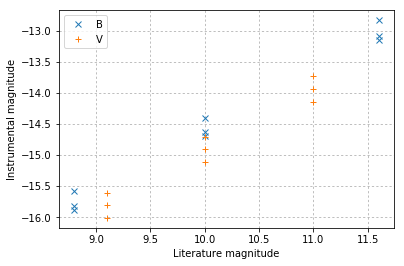

In [5]:
data_std = table.join(data, std, keys='Target')
# Joins two tables, data and std, based on the column 'Target'.
# Columns with name 'obj1' and 'obj2' does not exist in table std,
# so those rows will be deleted.
data_std.pprint(max_width=200)

print('Plot of literature VS instrumental magnitudes')
from matplotlib import pyplot as plt
plt.plot(data_std['B'], data_std['b'], marker='x', mfc='b', ls='', label='B')
plt.plot(data_std['V'], data_std['v'], marker='+', mfc='r', ls='', label='V')
plt.xlabel('Literature magnitude')
plt.ylabel('Instrumental magnitude')
plt.grid(ls=':')
plt.legend()
plt.show()

As you can see, the literature and the instrumental magnitude differ a lot, by roughly about 25 magnitude, but in a good linear relationship. Since the literature values are exact, we have to find a way to tune the instrumental magnitude to match the literature magnitudes. This is the standardization, as mentioned before. 

-----

## Example 3: Parameters for Standardization

We will start from the following formula:

\begin{align}
	v - V &=  z_{V} + k_{V} X \quad( + {\rm color~correction~terms})~,\\
    b - B &=  z_{B} + k_{B} X \quad( + {\rm color~correction~terms})~,
\end{align}

where $v(b)$ and $V(B)$ are the instrumental and literature magnitudes of standard stars. 

> ** How do we obtain the zero point ($z$) and the extinction coefficient ($k$)?**


Answer is very simple: Fit a line to ($v - V$) and ($b-B$) versus $X$!

I will use line fitting module from `scipy.optimize.curve_fit`, but you can also use `numpy.polyfit` or just make your own package to use. 

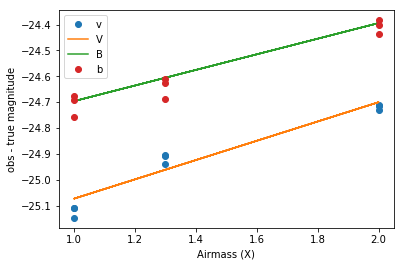

B: z_B & k_B = [-24.99762076   0.30163876]
V: z_V & k_V = [-25.44562147   0.37269281]


In [6]:
from scipy.optimize import curve_fit

# Define a function that will be used for fitting.
# Except for x, other two parameters (zero and k) should have 'default' value
# to be used in scipy.optimize.curve_fit.
def fitting(x, zero=0, k=1):
    return zero + k*x

vV = data_std['v'] - data_std['V']
bB = data_std['b'] - data_std['B']

# curve_fit gives two outputs: fitted parameters & covariance matrix
# The covariance matrix can be used for parameter error analysis and correlation check.
fitted_V = curve_fit(fitting, data_std['X'], vV, sigma=data_std['dv'])
fitted_B = curve_fit(fitting, data_std['X'], bB, sigma=data_std['db'])
fitpar_V = fitted_V[0] # contains z_V and k_V
fitpar_B = fitted_B[0] # contains z_B and k_B

# In Python, *something means you "unzip" the variable named "something".
# If something=[1, 2, 3], '*something' is identical to type '1, 2, 3'.
plt.plot(data_std['X'], vV, 'o')
plt.plot(data_std['X'], fitting(data_std['X'], *fitpar_V), label='V')
plt.plot(data_std['X'], fitting(data_std['X'], *fitpar_B), label='B')
plt.plot(data_std['X'], bB, 'o')
plt.xlabel('Airmass (X)')
plt.ylabel('obs - true magnitude')
plt.legend()
plt.show()
print('B: z_B & k_B =',fitpar_B)
print('V: z_V & k_V =',fitpar_V)


-----

## Example 4: Standardization with One More Color Term
Although we neglected the color terms in section 2.2, of course at some point you may want to get more accurate result. One possible way is to neglect the $k_{XC}$ term, but include $a$ term. Then you can combine the following two:

\begin{align}
	z_V' &= v - V - z_V \\
        &= k_V X + a_V({\rm B}-{\rm V}) \\
    z_B' &= b - v - z_C \\
        &= k_C X + a_C({\rm B}-{\rm V}) ~.
\end{align}
The subscript $C$ means color. 

In [7]:
def fitting2(INPUT, zero=0, k=1, a=1):
    X     = INPUT['X']
    COLOR = INPUT['COLOR']
    return zero + k*X + a*COLOR

vV = data_std['v'] - data_std['V']
bv = data_std['color']

fitted_vV = curve_fit(fitting2, data_std['X','COLOR'], vV)
fitpar_vV = fitted_vV[0]
fitted_bv = curve_fit(fitting2, data_std['X','COLOR'], bv)
fitpar_bv = fitted_bv[0]
print('v-V: z_V , k_V , a_V =',fitpar_vV)
print('b-v: z_C , k_C , a_C =',fitpar_bv)

v-V: z_V , k_V , a_V = [-25.4652505    0.38337417  -0.03535229]
b-v: z_C , k_C , a_C = [ 0.44555979 -0.07489208  0.95596985]
